In [1]:
import numpy as np 
from matplotlib import pyplot as plt
from os import listdir

In [2]:
# this function parses *.dat files and writes it into parsed/*.npy files, which can be read by np.loadtxt method
def parse_for_python(data_path):
    for file in listdir(data_path):
        if '.' in file and file.split('.')[1] == 'dat':
            with open(data_path + file, 'r') as src:
                with open(data_path + 'parsed/' + file.split('.')[0] + '.npy', 'w') as dst:
                    while True:
                        line = src.readline()
                        if line == '':
                            break
                        if line[-2] == ',':
                            dst.write(line[:-2] + '\n')
                        else:
                            dst.write(line)

S-parameters describe the response of an N-port network to signal(s) incident to any or all of the ports. The first number in the subscript refers to the responding port, while the second number refers to the incident port. Thus $S_{21}$ means the response at port 2 due to a signal at port 1.
![sparams-explanation](images/sparams-explanation.jpg)

Bistatic radar is a radar system comprising a transmitter and receiver that are separated by a distance comparable to the expected target distance. Conversely, a radar in which the transmitter and receiver are collocated is called a monostatic radar.
![bistatic and monostatic radars](images/radar-types.png)

In [3]:
# load bad data from a data file into matrix
bad_sand = np.loadtxt('data/test/parsed/s11-dbmag-bad-sandonly.npy', comments='%', delimiter=',').transpose()
bad_buried = np.loadtxt('data/test/parsed/s11-dbmag-bad-buried.npy', comments='%', delimiter=',').transpose()
# load good data from a data file into matrix
good_sand = np.loadtxt('data/test/parsed/s22-dbmag-good-sandonly.npy', comments='%', delimiter=',').transpose()
good_buried = np.loadtxt('data/test/parsed/s22-dbmag-good-buried.npy', comments='%', delimiter=',').transpose()

In [4]:
parse_for_python('data/test/')

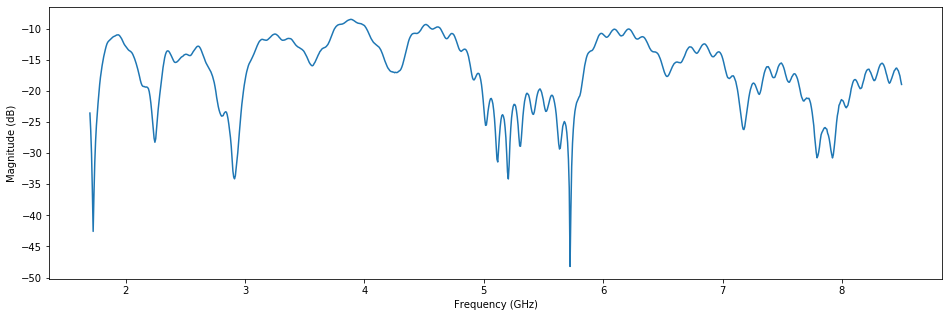

In [17]:
# plot typical data entry (in this case good_buried)
fig, ax = plt.subplots(figsize=(16, 5))
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Magnitude (dB)')

plt.plot(good_buried[0]/1e9, good_buried[1])
plt.show()

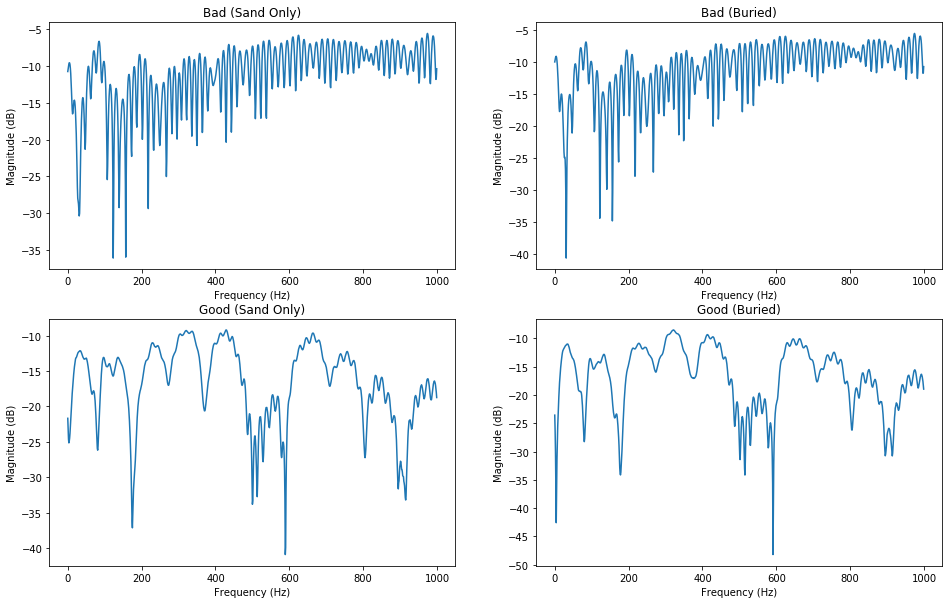

In [6]:
# we plot them without frequencies on x axis
fig = plt.figure(figsize=(16, 10))
axes = fig.subplots(2, 2)

axes[0, 0].plot(bad_sand[1])
axes[0, 0].set_title('Bad (Sand Only)')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Magnitude (dB)')

axes[0, 1].plot(bad_buried[1])
axes[0, 1].set_title('Bad (Buried)')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Magnitude (dB)')

axes[1, 0].plot(good_sand[1])
axes[1, 0].set_title('Good (Sand Only)')
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Magnitude (dB)')

axes[1, 1].plot(good_buried[1])
axes[1, 1].set_title('Good (Buried)')
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Magnitude (dB)')

plt.show()

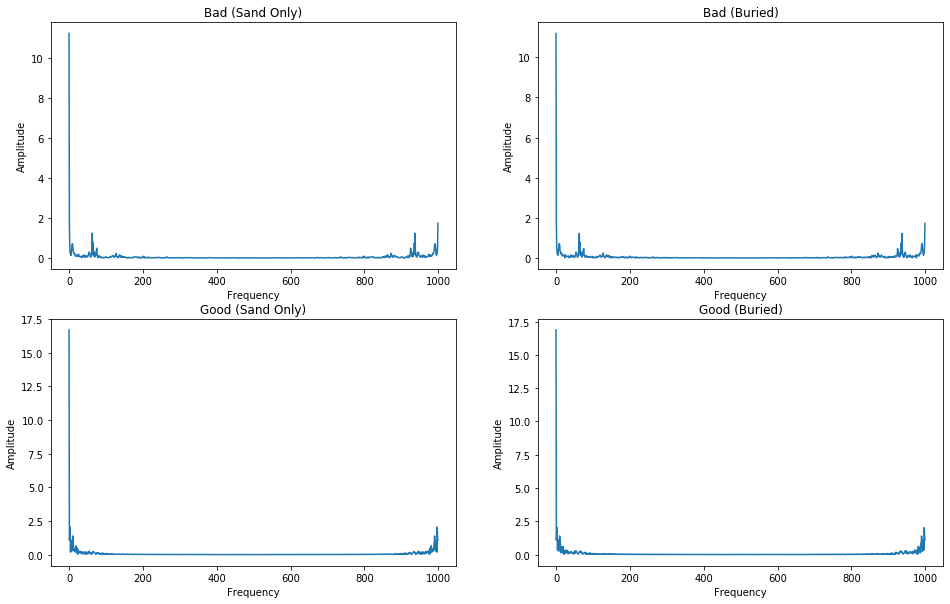

In [15]:
# next, we transform this signal using ifft
fig = plt.figure(figsize=(16, 10))
axes = fig.subplots(2, 2)

axes[0, 0].plot(np.abs(ifft(bad_sand[1])))
axes[0, 0].set_title('Bad (Sand Only)')
axes[0, 0].set_xlabel('Frequency')
axes[0, 0].set_ylabel('Amplitude')

axes[0, 1].plot(np.abs(ifft(bad_buried[1])))
axes[0, 1].set_title('Bad (Buried)')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('Amplitude')

axes[1, 0].plot(np.abs(ifft(good_sand[1])))
axes[1, 0].set_title('Good (Sand Only)')
axes[1, 0].set_xlabel('Frequency')
axes[1, 0].set_ylabel('Amplitude')

axes[1, 1].plot(np.abs(ifft(good_buried[1])))
axes[1, 1].set_title('Good (Buried)')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Amplitude')

plt.show()

Initial observation is that directly ifft-ing data from monostatic radar doesn't give much difference with either good or bad calibration. This, however, was expected. Measured S-parameters must go through some signal processing to get a tangible result. There are different signal processing techniques on this matter, so I decided to each of them until I get a good result. 

First technique is from *Jorge Mario Morales Vargas*:
![signal-processing](images/signal-preprocessing.png)

In [8]:
# first, we try converting from dB to absolute scale and confirming that it works
dbmag = np.loadtxt('data/test/parsed/dbmag.npy', comments='%', delimiter=',').transpose()
linmag = np.loadtxt('data/test/parsed/linmag.npy', comments='%', delimiter=',').transpose()

Linear S-parameters are unitless. Since they are based on voltage waves, they are converted to decibel format by multiplying the log of the linear ratio by 20.

$S_{11}$(dB) = input reflection gain = $20\log{S_{11}}$

$S_{22}$(dB) = output reflection gain = $20\log{S_{22}}$

$S_{21}$(dB) = forward gain = $20\log{S_{21}}$

$S_{12}$(dB) = reverse gain = $20\log{S_{12}}$

So that, to convert from dB to linear (absolute) scale, formula is $S_{xy}(abs) = 10^{\frac{S_{xy}(dB)}{20}}$.

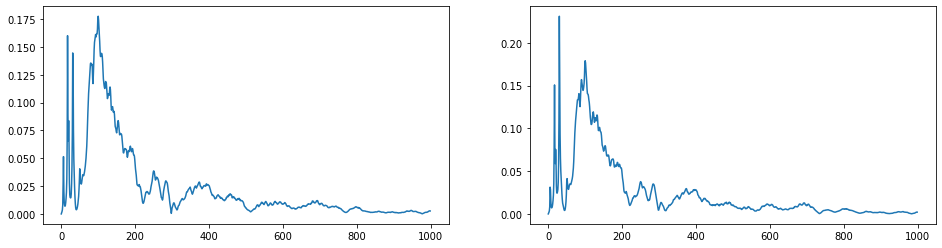

In [19]:
# functions below are indeed similar, so this is the correct conversion method
fig = plt.figure(figsize=(16, 4))
ax1, ax2 = fig.subplots(1, 2)

ax1.plot(10**(dbmag[1]/20))
ax2.plot(linmag[1])

plt.show()

Zero padding isn't needed, because $\cfrac{f_{start}}{\Delta f} < 1$.

At this point I realized that if we want to fully reconstruct time domain signal, we can't have absolute value of frequency response. We also need phase information, which is obviously missing from db**mag** and lin**mag** measurements. Our VNA had no convenient method of getting amplitude and phase information together (some VNAs can even return impulse response in time domain), so I only have absolute value to play with. However, this might be enough for creating a machine learning model.

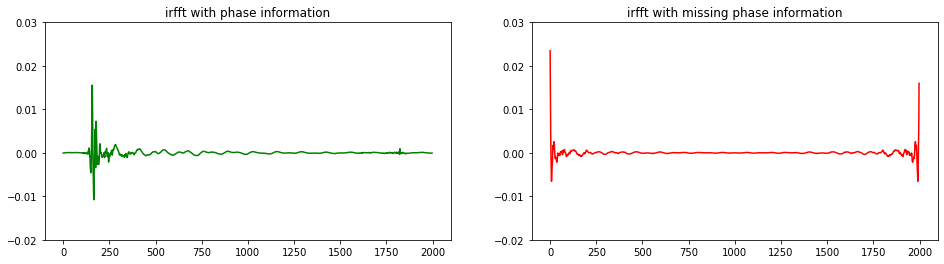

In [10]:
real = np.loadtxt('data/test/parsed/real.npy', comments='%', delimiter=',').transpose()
imag = np.loadtxt('data/test/parsed/imag.npy', comments='%', delimiter=',').transpose()
compx = real[1] + 1j*imag[1]

fig = plt.figure(figsize=(16, 4))
ax1, ax2 = fig.subplots(1, 2)

ax1.plot(np.fft.irfft(compx), 'g')
ax1.set_title('irfft with phase information')
ax1.set_ylim(-0.02, 0.03)

ax2.plot(np.fft.irfft(linmag[1]), 'r')
ax2.set_title('irfft with missing phase information')
ax2.set_ylim(-0.02, 0.03)

plt.show()

If we want to plot time on x axis, the time resolution can be calculated as follows: $\Delta t = \cfrac{1}{f_{stop}-f_{start}}$

delta_t = 0.11764844292285792ns


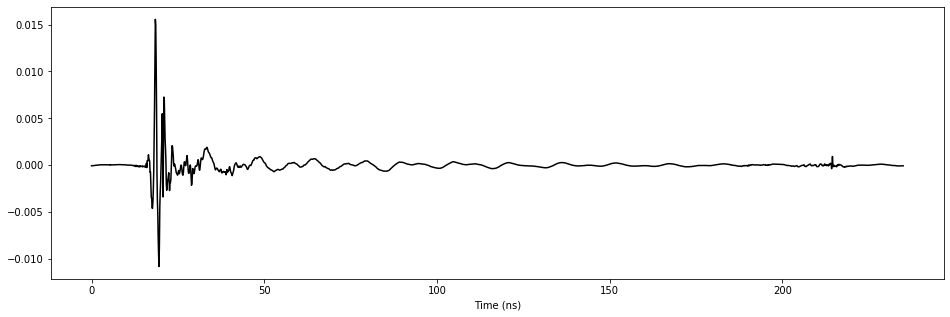

In [13]:
# calculate time step
delta_t = 1 / (linmag[0][-1] - linmag[0][0])
print('delta_t = ' + str(delta_t*1e9) + 'ns')

# create arrays for plotting
y = np.fft.irfft(compx)
t = np.arange(0, delta_t * len(y), delta_t)

plt.figure(figsize=(16, 5))
plt.xlabel('Time (ns)')
plt.plot(t*1e9, y, 'black')

plt.show()

# commit first